<sup>This notebook is originally from https://github.com/lizanafj/POE_techniques and licensed for reuse under [MIT license].</sup>

# Heating Thermostat Control Diagnosis
---

This notebook is part of a set of data-based fault detection and diagnosis techniques. 

Specifically, this notebook performs a **evaluation of the heating system control**. It quantifies the percentage of working hours where the indoor temperature is above or below the recommended temperature threshold. The approach also compares the relationship between the mean hourly indoor temperature and mean hourly outdoor temperature to understand the system operating conditions at full and partial-load operation. 

In [1]:
import os

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import datetime


# get folder location of script
cwd = os.getcwd()

## Import data
---
Import required data to perform the analysis

In [2]:
#Access to folder with data: 
os.chdir(cwd)
cwd_data = cwd+r"\Data"
os.chdir(cwd_data)

In [3]:
#data
int_data=pd.read_csv('HH_Indoor_Office_CO2sensor_2.csv',sep=";",index_col = "Time", parse_dates=True).tz_localize(None)

ext_data=pd.read_csv('HH_Outdoor_weather_2.csv',sep=";",index_col = "Time", parse_dates=True).tz_localize(None)


## Explore data
---
See variables, datetime, and data structure.

In [4]:
#See dataframe
int_data.head()

,Temp,RH,CO2
Time,,,
2022-05-06 11:00:00,25.817000,55.240000,455.955000
2022-05-06 12:00:00,25.457500,54.989250,416.655500
2022-05-06 13:00:00,25.333333,52.857667,400.155333
2022-05-06 14:00:00,25.629750,47.698000,413.641500
2022-05-06 15:00:00,25.743750,44.170500,402.409250


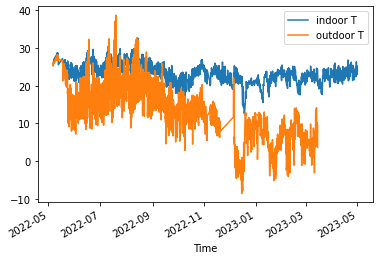

In [5]:
#Visualise variables
ax = int_data["Temp"].plot(label="indoor T")
ext_data["Temp_ext"].plot(ax=ax, label="outdoor T")
ax.legend()
plt.show()


## Data pre-processing
---

Filtering and cleaning steps before the analysis 


In [25]:
#Combine dataframes
data = pd.concat([int_data,ext_data],axis=1)

In [26]:
data.head()

,Temp,RH,CO2,Temp_ext,RH_ext
Time,,,,,
2022-05-06 11:00:00,25.817000,55.240000,455.955000,25.539000,54.480000
2022-05-06 12:00:00,25.457500,54.989250,416.655500,25.265917,53.562167
2022-05-06 13:00:00,25.333333,52.857667,400.155333,26.026200,50.677900
2022-05-06 14:00:00,25.629750,47.698000,413.641500,25.500500,46.133167
2022-05-06 15:00:00,25.743750,44.170500,402.409250,25.633417,41.968000


In [27]:
#truncate timeframe
data = data.truncate(before="2022-10-01",after="2023-03-31")

In [28]:
#Auxiliar variables
data["week_day"] = data.index.dayofweek
data["hour_day"] = data.index.hour
data["occupancy"] = np.where((data["hour_day"] > 8) & (data["hour_day"] < 18) & (data["week_day"]<5), 1, 0)


In [29]:
data.head()

,Temp,RH,CO2,Temp_ext,RH_ext,week_day,hour_day,occupancy
Time,,,,,,,,
2022-10-01 00:00:00,19.45600,55.26400,557.13250,12.646000,97.869250,5,0,0
2022-10-01 01:00:00,19.25100,55.16175,536.89675,12.033250,97.953250,5,1,0
2022-10-01 02:00:00,19.03275,55.10025,525.16700,11.322750,98.022500,5,2,0
2022-10-01 03:00:00,18.91325,55.14500,506.85200,11.649667,98.551333,5,3,0
2022-10-01 04:00:00,18.78700,55.28725,493.53125,11.591250,97.129250,5,4,0


## Data diagnosis
---
Diagnosis of heating system control at full and partial-load operation

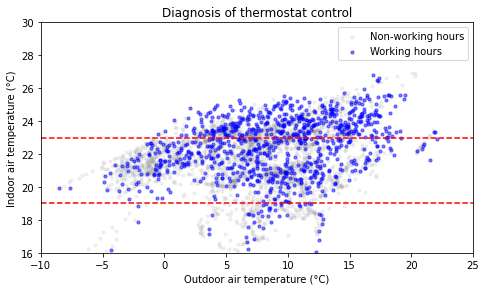

In [30]:
#Plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,0.8])

ax.scatter(data["Temp_ext"][(data["occupancy"]==0)],data["Temp"][(data["occupancy"]==0)], c="grey", alpha=0.1,marker="o",s=10, label="Non-working hours")
ax.scatter(data["Temp_ext"][(data["occupancy"]==1)],data["Temp"][(data["occupancy"]==1)], c="b", alpha=0.5,marker="o",s=10, label="Working hours")

ax.set_xlabel('Outdoor air temperature (°C)')
ax.set_ylabel('Indoor air temperature (°C)')
ax.set_title('Diagnosis of thermostat control')
ax.set_xlim(-10,25)
ax.set_ylim(16,30)
ax.legend()

plt.axhline(y=19, color='r', linestyle='--')

plt.axhline(y=23, color='r', linestyle='--')

plt.show()

In [31]:
#Statistics
data["discomfort"] = np.where((data["Temp"] > 23) & (data["occupancy"]==1), 1, 0)

overheating = data["discomfort"].values.sum()/data["occupancy"].values.sum()

In [39]:
print("Percentage of time with indoor temperature > 23°C: ",round(overheating*100,2),"%")

Percentage of time with indoor temperature > 23°C:  42.23 %
